# Word2Vec from scratch: 
- Take a large corpus of text
- Every word in a fixed wocabulary is represented by a vector
- Go through each position $t$ in the text which has a center word $c$ and context $o$
- Use the similarity of word vectors for $c$ and $o$ to calculate the probability of $o$ given $c$: $P(\{w_o\}|w_c)$
- Keep adjusting the word vectors to maximise this probability

Likelihood:
$$L(\theta) = \prod_{t=1}^T\prod_{-m\leq j\leq m} P(w_{t+j}|w_t;\theta)$$
where we optimise the parameters of $\theta$. We optimise the loss function:
$$J(\theta) = - \frac{1}{T} \sum_{t=1}^T\sum_{-m\leq j\leq m} \text{log}(P(w_{t+j}|w_t;\theta))$$
How do we calculate the likelihood?
We use two vectors per word:
- $v_w$ when $w$ is the center word
- $u_w$ when $w$ where the word is an outside word

so that for each word in the context we have the likelihood:
$$P(o|c) = \frac{\exp(u_o^T v_c)}{\sum_{w\in V} \exp(u_w^T v_c)}$$
which is a softmax which normalises over all the possible words in the vocabulary.

### Forward Pass:
$$h = W_1 x$$
$$s = W_2 h_1$$
$$y_c = \text{softmax}(s)$$
with the loss given by
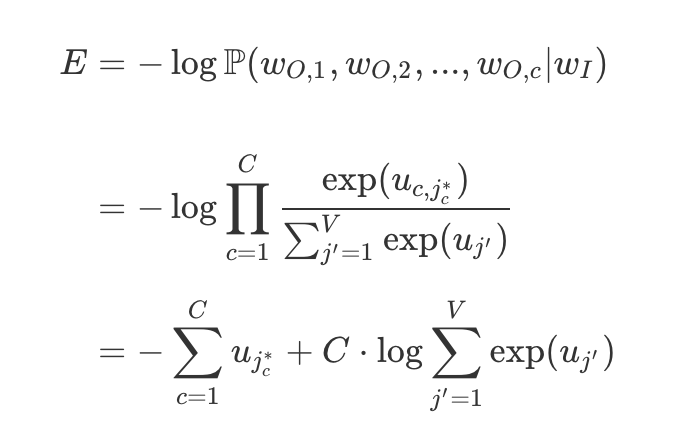


### Backward pass
$$\frac{\partial L}{\partial s_2 } = -2(y - s_2)$$

$$\partial L / \partial f_1 =  \frac{\partial L}{\partial s_2 }\frac{\partial s_2}{\partial f_1 } = -2(y - s_2)\cdot W_2$$

$$\partial L / \partial s_1 =  \frac{\partial L}{\partial f_1 }\frac{\partial f_1}{\partial s_1 } \quad \text{where} \quad \frac{\partial f_1}{\partial s_1 } = f_1(1-f_1)$$

So the weight updates (this comes from the fact that multiplication "switches" the gradients between two inputs - in this case the weights and the inputs):
$$ \frac{\partial L}{\partial W_2 } = f_1\cdot\frac{\partial L}{\partial s_2 }$$
$$ \frac{\partial L}{\partial W_1 } = \frac{\partial L}{\partial s_1 } \cdot x^T$$
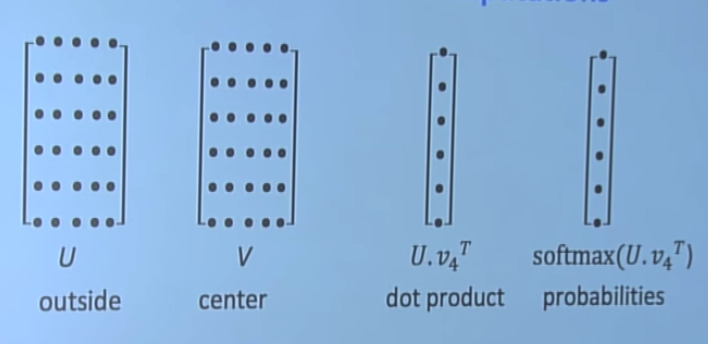

In [ ]:
class Word2Vec:
    def __init__():
        pass
    
    def forward():
        
    
    def softmax(self, x):
        """Compute the softmax of vector x in a numerically stable way."""
        shiftx = x - np.max(x)
        exps = np.exp(shiftx)
        return exps/np.sum(exps, axis=0).reshape(1, -1)
    

In [3]:
import re
import numpy as np

In [31]:


def tokenize(text):
    # obtains tokens with a least 1 alphabet
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

def mapping(tokens):
    word_to_id = dict()
    id_to_word = dict()

    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token

    return word_to_id, id_to_word

def generate_training_data(tokens, word_to_id, window_size):
    N = len(tokens)
    X, Y = [], []

    for i in range(N):
        nbr_inds = list(range(max(0, i - window_size), i)) + \
                   list(range(i + 1, min(N, i + window_size + 1)))
        for j in nbr_inds:
            X.append(word_to_id[tokens[i]])
            Y.append(word_to_id[tokens[j]])
            
    X = np.array(X)
    X = np.expand_dims(X, axis=0)
    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=0)

    return X, Y


doc = "After the deduction of the costs of investing, " \
      "beating the stock market is a loser's game."
tokens = tokenize(doc)
word_to_id, id_to_word = mapping(tokens)
X, Y = generate_training_data(tokens, word_to_id, 3)
vocab_size = len(id_to_word)
m = Y.shape[1]
# turn Y into one hot encoding
Y_one_hot = np.zeros((vocab_size, m))
Y_one_hot[Y.flatten(), np.arange(m)] = 1

In [6]:
def initialize_wrd_emb(vocab_size, emb_size):
    """
    vocab_size: int. vocabulary size of your corpus or training data
    emb_size: int. word embedding size. How many dimensions to represent each vocabulary
    """
    WRD_EMB = np.random.randn(vocab_size, emb_size) * 0.01
    return WRD_EMB

def initialize_dense(input_size, output_size):
    """
    input_size: int. size of the input to the dense layer
    output_szie: int. size of the output out of the dense layer
    """
    W = np.random.randn(output_size, input_size) * 0.01
    return W

def initialize_parameters(vocab_size, emb_size):
    """
    initialize all the trianing parameters
    """
    WRD_EMB = initialize_wrd_emb(vocab_size, emb_size)
    W = initialize_dense(emb_size, vocab_size)
    
    parameters = {}
    parameters['WRD_EMB'] = WRD_EMB
    parameters['W'] = W
    
    return parameters

In [52]:
def ind_to_word_vecs(inds, parameters):
    """
    inds: numpy array. shape: (1, m)
    parameters: dict. weights to be trained
    """
    m = inds.shape[1]
    WRD_EMB = parameters['WRD_EMB']
    word_vec = WRD_EMB[inds.flatten(), :].T
    assert(word_vec.shape == (WRD_EMB.shape[1], m))
    
    return word_vec

def linear_dense(word_vec, parameters):
    """
    word_vec: numpy array. shape: (emb_size, m)
    parameters: dict. weights to be trained
    """
    m = word_vec.shape[1]
    W = parameters['W']
    Z = np.dot(W, word_vec)
    
    assert(Z.shape == (W.shape[0], m))
    
    return W, Z

def softmax(Z):
    """
    Z: output out of the dense layer. shape: (vocab_size, m)
    """
    softmax_out = np.divide(np.exp(Z), np.sum(np.exp(Z), axis=0, keepdims=True) + 0.0001)
    
    assert(softmax_out.shape == Z.shape)

    return softmax_out

def forward_propagation(inds, parameters):
    word_vec = ind_to_word_vecs(inds, parameters)
    W, Z = linear_dense(word_vec, parameters)
    softmax_out = softmax(Z)
    
    caches = {}
    caches['inds'] = inds
    caches['word_vec'] = word_vec
    caches['W'] = W
    caches['Z'] = Z
    
    return softmax_out, caches

In [53]:
parameters = initialize_parameters(vocab_size, emb_size)
softmax_out, caches = forward_propagation(X, parameters)
softmax_out.shape

(13, 84)

In [54]:
np.sum(softmax_out, axis =0)

array([0.99999231, 0.99999231, 0.99999231, 0.99999231, 0.99999231,
       0.99999231, 0.99999231, 0.99999231, 0.99999231, 0.99999231,
       0.99999231, 0.99999231, 0.99999231, 0.99999231, 0.99999231,
       0.99999231, 0.99999231, 0.99999231, 0.99999231, 0.99999231,
       0.99999231, 0.99999231, 0.99999231, 0.99999231, 0.99999231,
       0.99999231, 0.99999231, 0.99999231, 0.99999231, 0.99999231,
       0.99999231, 0.99999231, 0.99999231, 0.99999231, 0.99999231,
       0.99999231, 0.99999231, 0.99999231, 0.99999231, 0.99999231,
       0.99999231, 0.99999231, 0.99999231, 0.99999231, 0.99999231,
       0.99999231, 0.99999231, 0.99999231, 0.99999231, 0.99999231,
       0.99999231, 0.99999231, 0.99999231, 0.99999231, 0.9999923 ,
       0.9999923 , 0.9999923 , 0.9999923 , 0.9999923 , 0.9999923 ,
       0.99999231, 0.99999231, 0.99999231, 0.99999231, 0.99999231,
       0.99999231, 0.99999231, 0.99999231, 0.99999231, 0.99999231,
       0.99999231, 0.99999231, 0.99999231, 0.99999231, 0.99999

In [33]:
# def cross_entropy(softmax_out, Y):
#     """
#     softmax_out: output out of softmax. shape: (vocab_size, m)
#     """
#     m = softmax_out.shape[1]
#     cost = -(1 / m) * np.sum(np.sum(Y * np.log(softmax_out + 0.001), axis=0, keepdims=True), axis=1)
#     return cost

def cross_entropy(softmax_out, Y):
    """
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    m = softmax_out.shape[1]
    cost = -(1 / m) * np.sum(np.log(softmax_out[Y.flatten(), np.arange(Y.shape[1])] + 0.001))
    return cost
  

In [34]:


def softmax_backward(Y, softmax_out):
    """
    Y: labels of training data. shape: (vocab_size, m)
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    m = Y.shape[1]
    softmax_out[Y.flatten(), np.arange(m)] -= 1.0
    dL_dZ = softmax_out
    
    assert(dL_dZ.shape == softmax_out.shape)
    return dL_dZ

def dense_backward(dL_dZ, caches):
    """
    dL_dZ: shape: (vocab_size, m)
    caches: dict. results from each steps of forward propagation
    """
    W = caches['W']
    word_vec = caches['word_vec']
    m = word_vec.shape[1]
    
    dL_dW = (1 / m) * np.dot(dL_dZ, word_vec.T)
    dL_dword_vec = np.dot(W.T, dL_dZ)

    assert(W.shape == dL_dW.shape)
    assert(word_vec.shape == dL_dword_vec.shape)
    
    return dL_dW, dL_dword_vec

def backward_propagation(Y, softmax_out, caches):
    dL_dZ = softmax_backward(Y, softmax_out)
    dL_dW, dL_dword_vec = dense_backward(dL_dZ, caches)
    
    gradients = dict()
    gradients['dL_dZ'] = dL_dZ
    gradients['dL_dW'] = dL_dW
    gradients['dL_dword_vec'] = dL_dword_vec
    
    return gradients

def update_parameters(parameters, caches, gradients, learning_rate):
    vocab_size, emb_size = parameters['WRD_EMB'].shape
    inds = caches['inds']
    WRD_EMB = parameters['WRD_EMB']
    dL_dword_vec = gradients['dL_dword_vec']
    m = inds.shape[-1]
    
    WRD_EMB[inds.flatten(), :] -= dL_dword_vec.T * learning_rate

    parameters['W'] -= learning_rate * gradients['dL_dW']

In [35]:
def skipgram_model_training(X, Y, vocab_size, emb_size, learning_rate, epochs, 
                            batch_size=256, parameters=None, print_cost=True, plot_cost=True):
    """
    X: Input word indices. shape: (1, m)
    Y: One-hot encodeing of output word indices. shape: (vocab_size, m)
    vocab_size: vocabulary size of your corpus or training data
    emb_size: word embedding size. How many dimensions to represent each vocabulary
    learning_rate: alaph in the weight update formula
    epochs: how many epochs to train the model
    batch_size: size of mini batch
    parameters: pre-trained or pre-initialized parameters
    print_cost: whether or not to print costs during the training process
    """
    costs = []
    m = X.shape[1]
    
    if parameters is None:
        parameters = initialize_parameters(vocab_size, emb_size)
    
    for epoch in range(epochs):
        epoch_cost = 0
        batch_inds = list(range(0, m, batch_size))
        np.random.shuffle(batch_inds)
        for i in batch_inds:
            X_batch = X[:, i:i+batch_size]
            Y_batch = Y[:, i:i+batch_size]

            softmax_out, caches = forward_propagation(X_batch, parameters)
            gradients = backward_propagation(Y_batch, softmax_out, caches)
            update_parameters(parameters, caches, gradients, learning_rate)
            cost = cross_entropy(softmax_out, Y_batch)
            epoch_cost += np.squeeze(cost)
            
        costs.append(epoch_cost)
        if print_cost and epoch % (epochs // 500) == 0:
            print("Cost after epoch {}: {}".format(epoch, epoch_cost))
        if epoch % (epochs // 100) == 0:
            learning_rate *= 0.98
            
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel('# of epochs')
        plt.ylabel('cost')
    return parameters

In [36]:
1500 // 500

3

In [37]:
emb_size = 100
learning_rate = 1
epochs = 500

skipgram_model_training(X, Y, vocab_size, emb_size, learning_rate, epochs)

AssertionError: 